In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



In [ ]:
df = pd.read_csv("smart_grid_fault_data.csv")
df.head()

,voltage,current,frequency,power_factor,fault_type
0,244.901425,60.990332,48.649643,0.891244,3
1,225.852071,53.869505,49.710963,0.990140,0
2,249.430656,40.894456,48.415160,0.555803,2
3,275.690896,30.295948,49.384077,0.981834,0
4,222.975399,50.473350,46.212771,0.658740,0


In [ ]:
df.isnull().sum()

# Encode categorical if needed
df["fault_type"] = df["fault_type"].astype("category").cat.codes

# Features and Labels
X = df.drop(["fault_type"], axis=1)
y = df["fault_type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Accuracy: 0.565
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.93      0.74       121
           1       0.12      0.04      0.06        23
           2       0.00      0.00      0.00        23
           3       0.00      0.00      0.00        17
           4       0.00      0.00      0.00        16

    accuracy                           0.56       200
   macro avg       0.15      0.19      0.16       200
weighted avg       0.38      0.56      0.45       200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


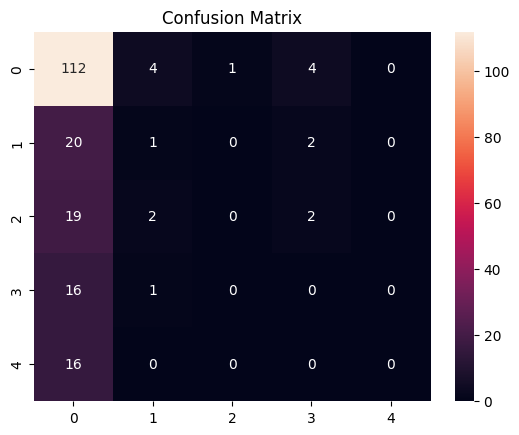

In [ ]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)
print("Classification Report:\n", classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
def self_healing(predicted_fault):
    healing_steps = {
        0: "No action needed (Normal)",
        1: "Isolate phase-A, reroute power",
        2: "Bypass transformer T1, switch to backup",
        3: "Switch to UPS supply",
        4: "Auto-reset breaker and monitor"
    }
    return healing_steps.get(predicted_fault, "Unknown Fault")

In [ ]:
import joblib
joblib.dump(model, "fault_detection_model.pkl")

['fault_detection_model.pkl']

In [ ]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.8 MB/s eta 0:00:00


In [30]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import time

# Load model
model = joblib.load("fault_detection_model.pkl")

st.set_page_config(page_title="Smart Grid Fault System", layout="centered")
st.title("⚡ Smart Grid Fault Detection & Self-Healing")
st.markdown("This system detects electrical faults and provides a recommended self-healing action in real-time.")

# Sidebar Inputs
st.sidebar.header("Input Grid Parameters")
input_data = {
    "voltage": st.sidebar.slider("Voltage (V)", 100, 300, 230),
    "current": st.sidebar.slider("Current (A)", 10, 100, 40),
    "frequency": st.sidebar.slider("Frequency (Hz)", 45, 55, 50),
    "power_factor": st.sidebar.slider("Power Factor", 0.4, 1.0, 0.9)
}
input_df = pd.DataFrame([input_data])

# Self-Healing function (static graph)
def self_healing(predicted_fault):
    healing_steps = {
        0: "No action needed (Normal)",
        1: "Isolate phase-A, reroute power",
        2: "Bypass transformer T1, switch to backup",
        3: "Switch to UPS supply",
        4: "Auto-reset breaker and monitor"
    }
    explanation = healing_steps.get(predicted_fault, "Unknown Fault")

    # Generate static graph
    fig, ax = plt.subplots()
    time_vals = np.linspace(0, 10, 100)

    if predicted_fault == 0:
        voltage = 230 + np.random.normal(0, 2, 100)
        ax.plot(time_vals, voltage, label="Stable Voltage", color='green')
        ax.set_title("Normal Grid Condition")
    elif predicted_fault == 1:
        voltage = np.where(time_vals < 5, 110, 230)
        ax.plot(time_vals, voltage, label="Phase-A Fault Recovered", color='red')
        ax.axvline(x=5, linestyle='--', color='blue', label='Recovery Point')
        ax.set_title("Phase-A Isolation & Reroute")
    elif predicted_fault == 2:
        voltage = np.where(time_vals < 6, 150, 230)
        ax.plot(time_vals, voltage, label="Transformer Bypass", color='orange')
        ax.set_title("Transformer Bypassed, Backup Active")
    elif predicted_fault == 3:
        voltage = np.where(time_vals < 4, 0, 220)
        ax.plot(time_vals, voltage, label="UPS Activated", color='purple')
        ax.set_title("UPS Switched In")
    elif predicted_fault == 4:
        voltage = np.where(time_vals < 3, 100, 230)
        ax.plot(time_vals, voltage, label="Breaker Reset", color='brown')
        ax.set_title("Auto Breaker Reset")

    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Voltage (V)")
    ax.legend()
    ax.grid(True)

    return explanation, fig

# 🔍 Fault Detection & Healing Output
if st.button("🔍 Detect Fault"):
    prediction = model.predict(input_df)[0]
    explanation, fig = self_healing(prediction)

    # Display outputs
    st.metric("Detected Fault Code", prediction)
    st.info(f"🛠️ Self-Healing Action: {explanation}")
    st.pyplot(fig)

    # Logging
    with open("fault_logs.txt", "a") as log:
        log.write(f"{datetime.now()}, Input: {input_data}, Fault: {prediction}, Action: {explanation}\n")

    st.success("Detection and action completed.")

# ▶️ Live Simulation of Grid Parameters
if st.button("▶️ Run Live Simulation"):

    st.subheader("📊 Real-Time Parameter Simulation (with Fault Recovery)")

    chart_area = st.empty()
    time_steps = np.linspace(0, 10, 100)

    voltage_data = []
    current_data = []
    freq_data = []
    pf_data = []

    for t in range(100):
        # Fault for first 50 steps, then recovery
        if t < 50:
            voltage = input_data["voltage"] / 2
            current = input_data["current"] / 2
            frequency = input_data["frequency"] - 3
            pf = 0.6
        else:
            voltage = 230
            current = 40
            frequency = 50
            pf = 0.95

        voltage_data.append(voltage)
        current_data.append(current)
        freq_data.append(frequency)
        pf_data.append(pf)

        fig, axs = plt.subplots(2, 2, figsize=(10, 6))
        axs[0, 0].plot(time_steps[:t+1], voltage_data, color="red")
        axs[0, 0].set_title("Voltage (V)")
        axs[0, 0].grid(True)

        axs[0, 1].plot(time_steps[:t+1], current_data, color="blue")
        axs[0, 1].set_title("Current (A)")
        axs[0, 1].grid(True)

        axs[1, 0].plot(time_steps[:t+1], freq_data, color="purple")
        axs[1, 0].set_title("Frequency (Hz)")
        axs[1, 0].grid(True)

        axs[1, 1].plot(time_steps[:t+1], pf_data, color="green")
        axs[1, 1].set_title("Power Factor")
        axs[1, 1].grid(True)

        for ax in axs.flat:
            ax.set(xlabel="Time (s)")
        plt.tight_layout()
        plt.subplots_adjust(top=0.88)

        chart_area.pyplot(fig)
        time.sleep(0.05)

    st.success("✅ Simulation Complete")

Overwriting app.py


In [15]:
!pip install streamlit --quiet

In [25]:
!npm install -g localtunnel

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙
changed 22 packages in 2s
⠙
⠙3 packages are looking for funding
⠙  run `npm fund` for details
⠙

In [31]:
!streamlit run app.py & npx localtunnel --port 8501

⠙

⠹⠸⠼⠴⠦
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.106.80.156:8501

⠧your url is: https://cool-clowns-cough.loca.lt
/content/app.py:117: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(2, 2, figsize=(10, 6))
/content/app.py:117: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(2, 2, figsize=(10, 6))
2025